In [1]:
#Necessary imports
import IPython.display as ipd
import math 
from keras.models import load_model
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [2]:
#We specify the paths to the best model and out audio files.
#The audios are the same, whose pictures are in the paper.
MODELPATH = "/content/modelv14-15-0.0337.hdf5"
NOISY_PATH = "/content/p234_002_noisy.wav"
CLEAN_PATH = "/content/p234_002_clean.wav"

In [3]:
#We load the model here from the specified path.
model = load_model(MODELPATH)

In [6]:
#The model was trained with 16kHz samplerate audio files, split into slices of 2048 floats.
TARGET_SR=16000
SLICE_SIZE=2048

#This function calculates the peak amplitude of a sound sample. We use this to normalize the sound samples between -1, 1.
def peak_amplitude(samples):
    return max(abs(np.min(samples)), abs(np.max(samples)))

#This function reshapes the slice to the model's input dimensions, and returns the correctly reshaped output of the prediction.
def _model_predict(slice):
    return np.array(model.predict(slice.reshape((1, SLICE_SIZE)))[0]).reshape((SLICE_SIZE))

#This function makes the denoised audio, by calling the _model_predict function on all slices, and concatenating them to each other.
def _denoise_audio(audio, result):
    slice_count = audio.shape[0] // SLICE_SIZE
    for i in range(0, slice_count * SLICE_SIZE, SLICE_SIZE):
        result[i:i+SLICE_SIZE] += _model_predict(audio[i:i+SLICE_SIZE])
        
#This function normalizes the audio, then pads the last slice to a whole slice by zeropadding, calls the denoising function, and returns the result with the correct length, denormalized.
def denoise_audio(audio):
    peak = peak_amplitude(audio)
    npad = math.ceil(audio.shape[0] / SLICE_SIZE) * SLICE_SIZE
    padded = np.pad(audio, (0, npad), 'reflect')
    result = np.zeros(padded.shape)
    _denoise_audio(padded / peak, result)
    return result[:audio.shape[0]] * peak

#This function reads the noisy and clean audios, denoises it, using the model and plots the noisy, predicted, clean audios, respectively.
def plot():
    tsr = TARGET_SR
    noisy_res, _ = librosa.load(NOISY_PATH, sr=tsr, res_type='kaiser_best')
    clean_res, _ = librosa.load(CLEAN_PATH, sr=tsr, res_type='kaiser_best')
    result = denoise_audio(noisy_res)
    print('Original noisy audio:')
    plt.ylim((-0.04, 0.04))
    plt.plot(noisy_res[0:256])
    plt.show()
    print('Denoised audio:')
    plt.ylim((-0.04, 0.04))
    plt.plot(result[0:256])
    plt.show()
    print('Original clean audio:')
    plt.ylim((-0.04, 0.04))
    plt.plot(clean_res[0:256])
    plt.show()

Original noisy audio:


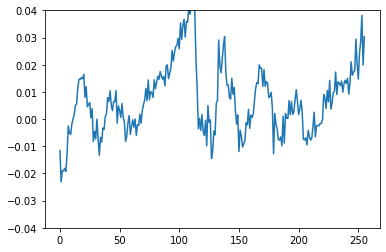

Denoised audio:


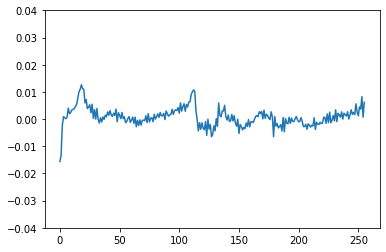

Original clean audio:


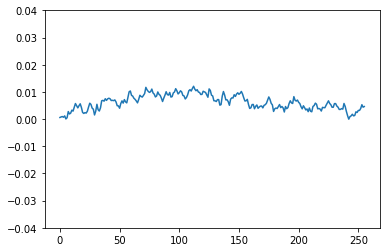

In [7]:
plot()